# 메인퀘스트 1

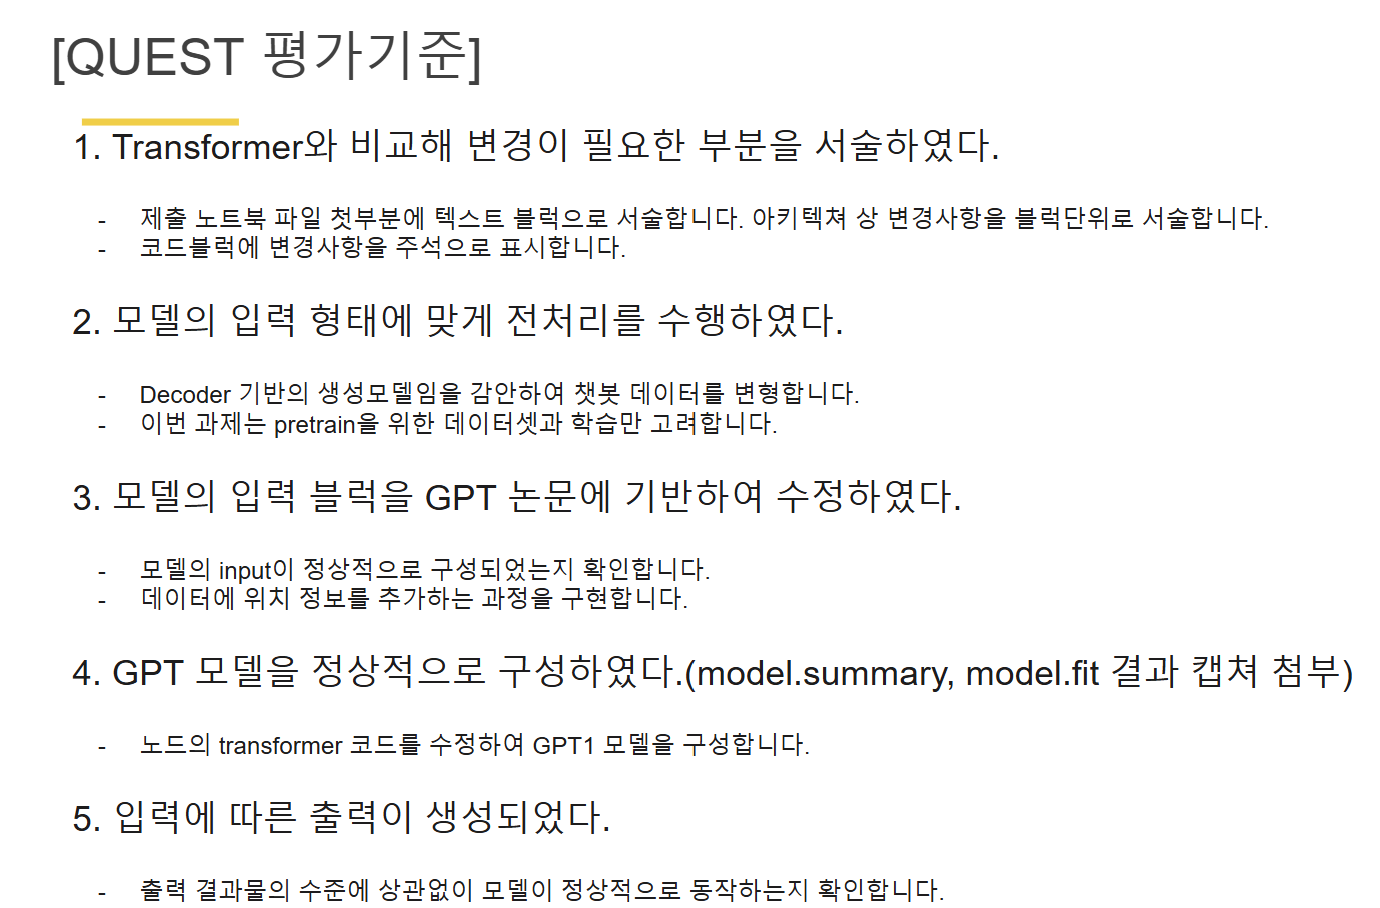

## *기존 Transformer에서의 변경 사항 :*  

- 데이터 변경사항
1. 교사강요 모델 : dataset의 encoder의 inputs 제거하고 dec_inputs만 사용(dec_inputs만->inputs으로 이름 변경함)   

- 모델 변경사항
1. PositionalEncoding -> PositionEmbedding 으로 변경
2. multi-layer Transformer decoder 부분만 사용, encoder 제거
3. decoder의 encoder-decoder attention 제거
4. dense layer에서 softmax 활성화함수 사용
5. 손실함수의 from_logits: True -> False로 변경
6. dataset의 텐서 변경에 따른 decoder_inference 모델의 입력 텐서 변경  

**변경사항이 있을 때 제목에 (변경사항 있음)으로 표기하고 코드 블럭 주석으로 표시 및 코드 블록 아래에 텍스트 블럭으로 설명하였습니다.**

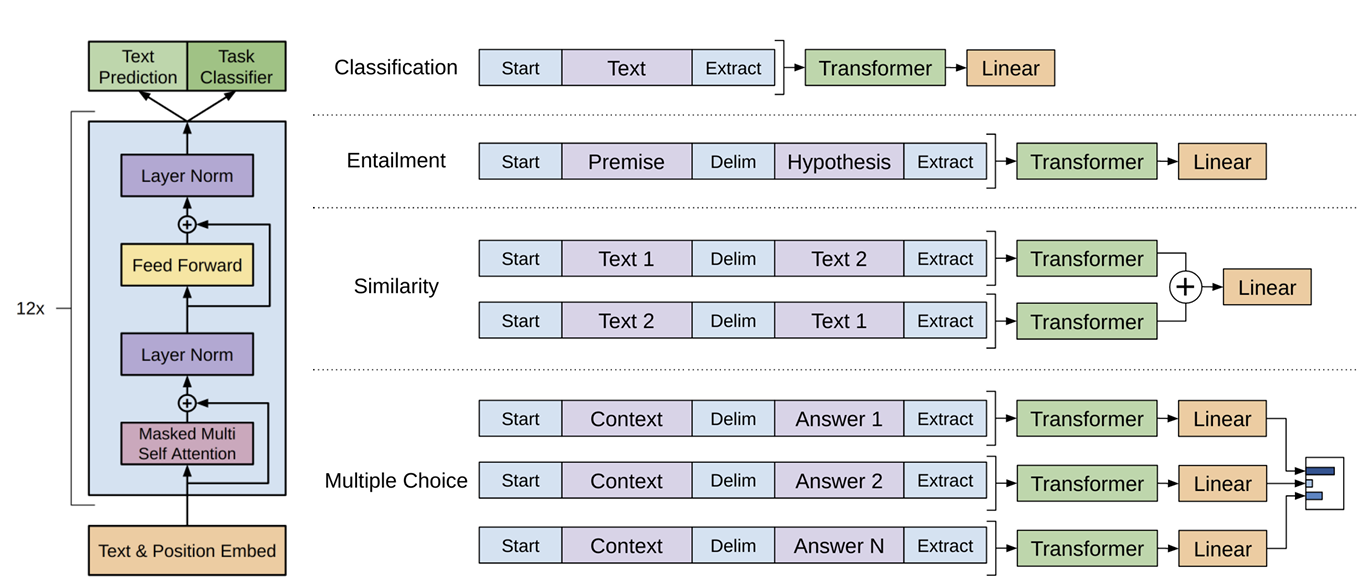

## 1. 라이브러리 설치

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


## 2. 데이터셋 가져오기

In [2]:
root_dir = os.getcwd()

# path_to_dataset = os.path.join(root_dir, "ChatbotData.csv")
path_to_dataset = "data/ChatbotData.csv"

data = pd.read_csv(path_to_dataset)

data.sample(10)

,Q,A,label
10807,오래 만났어,사랑은 유지하는 게 중요한데 대단하네요.,2
487,나 모르는게 왜 이렇게 많지,당연한 거예요.,0
5114,헬스장 사람들 몸이 좋아,운동할 맛 나겠어요.,0
5422,SNS 흔적,SNS 흔적 삭제하세요.,1
5478,걸지 못한 전화,걸지 말아요.,1
2322,살이 안 쪄,신기하네요.,0
9945,사랑하냐고 왜 물어봐?,확인 받고 싶어서요.,2
8514,헤어지고 1주에 한번은 뭐라도 오네,제대로 헤어지지 못했군요.,1
4212,좌절 중이야,이제 일어날 때예요.,0
9669,마음 표현하기가 힘들어,표현도 연습해야 해요.,2


## 3. 데이터 전처리

In [3]:
# 결측치 확인

print(data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [4]:
# 전처리 함수
def preprocess_sentence(sentence):

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (ㄱ-ㅎ, ㅏ-ㅣ, 가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣\.\?\!,]", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [5]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_answer():

  inputs, outputs = [], []

  for i in range(len(data)):
      question = data["Q"].iloc[i]  # 질문
      answer = data["A"].iloc[i]  # 답변

      # 전처리 함수 적용
      inputs.append(preprocess_sentence(question))
      outputs.append(preprocess_sentence(answer))

  return inputs, outputs

In [6]:
# 샘플 수 확인

questions, answers = load_answer()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [7]:
# 샘플 확인
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## 4. 병렬 데이터 전처리하기 (변경사항 있음)  

교사 강요 수정 (inputs 삭제)

### 단어장 만들기

In [8]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [9]:
print(tokenizer.subwords[:100])

[' .', ' ?', '거예요', '수_', '게_', '너무_', '더_', '거_', '는_', '좋아하는_', ' . ', '이_', '을_', '잘_', '도_', '고_', '요', '것_', '많이_', '안_', '좋은_', '같아요', '좀_', '한_', '있어요', '싶어', '나_', '가_', '있을_', '에_', '해보세요', '지_', '사람_', '은_', '할_', '해', '같아', '네', '면_', '건_', '를_', ' !', '사람이_', '마세요', '다_', '지', '하고_', '  ', '하는_', '보세요', '죠', '어', '서_', '내가_', '다', '내_', '마음이_', '의_', '나', '이제_', '다른_', '썸_', '만_', '그_', '어떻게_', '있는_', '왜_', '싶다', '세요', '다시_', '시간이_', '수도_', '없어', '또_', '것도_', '좋을_', '오늘_', '가', '이', '정말_', '같이_', '네요', '될_', '해요', '자꾸_', '일_', '걸_', '있어', '하세요', '없어요', '길_', '바랄게요', '로_', '제가_', '까', '돼요', '하면_', '봐요', '할까', '이별']


In [10]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [11]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8140]
END_TOKEN의 번호 : [8141]


In [12]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8142


### 단어 인코딩 & 패딩

In [13]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5755, 613, 2494, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2361, 7492, 7, 6257, 98, 1]


In [14]:
# maxlen 계산하기

total_data_text = list(questions) + list(answers)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  14.620231751670472
문장길이 최대 :  78
문장길이 표준편차 :  6.743414533008147
pad_sequences maxlen :  28
전체 문장의 0.9617694324621501%가 maxlen 설정값 이내에 포함됩니다. 


In [15]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 28
print(MAX_LENGTH)

28


In [16]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 28 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 28으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [17]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8142
필터링 후의 질문 샘플 개수: 11821
필터링 후의 답변 샘플 개수: 11821


### 교사 강요 사용하기  -> inputs 삭제, dec_input -> inputs으로 변경
교사 강요를 하지 않은 경우, 잘못된 예측이 다음 시점(time step)의 입력으로 들어가면서 연쇄적으로 예측 정확도에 영향을 미친다.

In [18]:
BATCH_SIZE = 64
# 작업 시에 CPU가 처리하는 정보의 양
BUFFER_SIZE = 5000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
#         'inputs': questions,                                    # 변경사항 : inputs 삭제 및 dec_inputs -> inputs으로 이름 변경
        'inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# inputs, outputs shape 확인
# print(questions.shape)
print(answers[:, :-1].shape)
print(answers[:, 1:].shape)

(11821, 27)
(11821, 27)


# *변경사항 : inputs 삭제, dec_input -> inputs으로 변경*  

- GPT1 모델에서는 encoder를 사용하지 않으므로 decoder에 필요한 입력 데이터로 변경

## 5. 모델 정의  (변경사항 있음)  
PositionalEncoding -> PositionEmbedding 으로 변경, 인코더 제거, 디코더의 인코더-디코더 어텐션 제거, 트랜스포머 층의 인코더 제거, softmax 추가)

### 포지셔널 인코딩 : PositionalEncoding -> PositionEmbedding 으로 변경¶

In [19]:
# # 포지셔널 인코딩 레이어
# class PositionalEncoding(tf.keras.layers.Layer):

#   def __init__(self, position, d_model):
#     super(PositionalEncoding, self).__init__()
#     self.pos_encoding = self.positional_encoding(position, d_model)
    

#   def get_angles(self, position, i, d_model):
#     angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
#     return position * angles


#   def positional_encoding(self, position, d_model):
#     # 각도 배열 생성
#     angle_rads = self.get_angles(
#         position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
#         i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
#         d_model=d_model)

#     # 배열의 짝수 인덱스에는 sin 함수 적용
#     sines = tf.math.sin(angle_rads[:, 0::2])
#     # 배열의 홀수 인덱스에는 cosine 함수 적용
#     cosines = tf.math.cos(angle_rads[:, 1::2])

#     # sin과 cosine이 교차되도록 재배열
#     pos_encoding = tf.stack([sines, cosines], axis=0)
#     pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
#     pos_encoding = tf.reshape(pos_encoding, [position, d_model])

#     pos_encoding = pos_encoding[tf.newaxis, ...]
#     return tf.cast(pos_encoding, tf.float32)

#   def call(self, inputs):
#     # 희소 행렬을 덧셈 연산에 맞게 처리
#     if isinstance(inputs, tf.sparse.SparseTensor):
#       # SparseTensor에 대해 덧셈 연산을 수행
#       return tf.sparse.add(inputs, self.pos_encoding[:, :tf.shape(inputs)[1], :])
#     else:
#       # 밀집 행렬일 경우 일반 덧셈 처리
#       return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [20]:
# 포지션 임베딩 레이어
class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model):
        super(PositionEmbedding, self).__init__()
        self.max_len = max_len
        self.d_model = d_model
        
        # 각 위치에 대해 학습 가능한 임베딩을 생성
        self.position_embeddings = tf.keras.layers.Embedding(input_dim=max_len, output_dim=d_model)

    def call(self, inputs):
        # 입력 시퀀스의 길이를 얻기 위해 inputs의 shape에서 seq_len을 가져옴
        seq_len = tf.shape(inputs)[1]

        # 각 위치에 대한 임베딩을 추출하여 입력에 더함
        position_indices = tf.range(seq_len)
        position_embeddings = self.position_embeddings(position_indices)  # (seq_len, d_model)

        # inputs에 포지션 임베딩을 더해줌
        return inputs + position_embeddings


# *변경사항 :PositionalEncoding -> PositionEmbedding 으로 변경*

포지셔널 인코딩과 포지션 임베딩의 차이  
포지셔널 인코딩은 고정된 파라미터를 입력 데이터에 더해준다.  
하지만 포지션 임베딩은 학습 가능한 파라미터 값을 입력 데이터에 더해준다

In [21]:
# # 포지셔닝 벡터 시각화

# sample_pos_encoding = PositionalEncoding(50,512)

# plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
# plt.xlabel('Depth')
# plt.xlim((0, 512))
# plt.ylabel('Position')
# plt.colorbar()
# plt.show()

### 스케일드 닷 프로덕트 어텐션 함수

In [22]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output



### 멀티 헤드 어텐션

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs


### 패딩 마스킹 구현

In [24]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

### 룩 어헤드 마스킹 구현

In [25]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### 인코더 층 -> 주석처리

In [26]:
# # 인코더 하나의 레이어를 함수로 구현.
# # 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
# def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
#   inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

#   # 패딩 마스크 사용
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

#   # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
#   attention = MultiHeadAttention(
#       d_model, num_heads, name="attention")({
#           'query': inputs,
#           'key': inputs,
#           'value': inputs,
#           'mask': padding_mask
#       })

#   # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
#   attention = tf.keras.layers.Dropout(rate=dropout)(attention)
#   attention = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(inputs + attention)

#   # 두 번째 서브 레이어 : 2개의 완전연결층
#   outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
#   outputs = tf.keras.layers.Dense(units=d_model)(outputs)

#   # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
#   outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
#   outputs = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(attention + outputs)

#   return tf.keras.Model(
#       inputs=[inputs, padding_mask], outputs=outputs, name=name)

# *변경사항 : 인코더 층 사용하지 않음*

### 인코더 층 쌓기 -> 주석처리

In [27]:
# def encoder(vocab_size,
#             num_layers,
#             units,
#             d_model,
#             num_heads,
#             dropout,
#             name="encoder"):
#   inputs = tf.keras.Input(shape=(None,), name="inputs")

#   # 패딩 마스크 사용
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

#   # 임베딩 레이어
#   embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
#   embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

#   # 포지셔널 인코딩
#   embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

#   outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

#   # num_layers만큼 쌓아올린 인코더의 층.
#   for i in range(num_layers):
#     outputs = encoder_layer(
#         units=units,
#         d_model=d_model,
#         num_heads=num_heads,
#         dropout=dropout,
#         name="encoder_layer_{}".format(i),
#     )([outputs, padding_mask])

#   return tf.keras.Model(
#       inputs=[inputs, padding_mask], outputs=outputs, name=name)

# *변경사항 : 인코더 층 사용하지 않음*

### 디코더 층 -> 인코더-디코더 어텐션 제거, enc_outputs 제거

In [28]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
#   enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")                 # 변경사항: enc_outputs 제거
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

# 변경사항 ; 인코더-디코더 어텐션 제거
#   # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
#   attention2 = MultiHeadAttention(
#       d_model, num_heads, name="attention_2")(inputs={
#           'query': attention1,
#           'key': enc_outputs,
#           'value': enc_outputs,
#           'mask': padding_mask
#       })

#   # 마스크드 멀티 헤드 어텐션의 결과는
#   # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
#   attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
#   attention2 = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)       # 변경사항: input: attention2 -> attention1
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)                                           # 변경사항: input: outputs + attention2 -> outputs + attention1

  return tf.keras.Model(
#       inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],                 # 변경사항 : enc_ouputs 제거
      inputs=[inputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# *변경사항 : 인코더-디코더 어텐션 제거, enc_outputs 제거*

### 디코더 층 쌓기 -> enc_outputs 제거, PositionalEncoding -> PositionEmbedding 으로 변경

In [29]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
#   enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')            # 변경사항 : enc_outputs 제거
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
#   embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)                       # 변경사항 : PositionalEncoding -> PositionEmbedding 으로 변경

  embeddings = PositionEmbedding(vocab_size, d_model)(embeddings) 

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
#     )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])     # 변경사항 : enc_outputs 제거
    )(inputs=[outputs, look_ahead_mask, padding_mask]) 
        
  return tf.keras.Model(
#       inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],      # 변경사항 : enc_outputs 제거
      inputs=[inputs, look_ahead_mask, padding_mask], 
      outputs=outputs,
      name=name)

# *변경사항 :enc_outputs 제거, PositionalEncoding -> PositionEmbedding 으로 변경*

### 트랜스포머 함수 정의 -> dec_inputs 제거,enc_padding_mask,인코더 층, enc_outputs 제거, softmax 활성화함수 추가

In [30]:
def GPT1(vocab_size,
         num_layers,
         units,
         d_model,
         num_heads,
         dropout,
         name="GPT1"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
#   dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")       # 변경사항: dec_inputs 제거

# 변경사항: 인코더 패딩 마스크 층 제거

#   # 인코더에서 패딩을 위한 마스크
#   enc_padding_mask = tf.keras.layers.Lambda(
#       create_padding_mask, output_shape=(1, 1, None),
#       name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(inputs)                                  # 변경사항: dec_inputs -> inputs

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

# 변경사항: 인코더 층 제거

#   # 인코더
#   enc_outputs = encoder(
#       vocab_size=vocab_size,
#       num_layers=num_layers,
#       units=units,
#       d_model=d_model,
#       num_heads=num_heads,
#       dropout=dropout,
#   )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
#   )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])              # 변경사항 : dec_inputs -> inputs으로 변경,enc_outputs 제거
  )(inputs=[inputs, look_ahead_mask, dec_padding_mask]) 

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, activation='softmax', name="outputs")(dec_outputs)            # 변경사항 : softmax 활성화함수 추가

#   return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)         # 변경사항: inputs, dec_inputs -> inputs
  return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name) 

# *변경사항 :  dec_inputs 제거, enc_padding_mask,인코더 층 제거, softmax 활성화함수 추가*

## 6. 모델 생성 (변경사항 있음)  
손실함수에서 from_logits 옵션 True -> False로 변경

In [71]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 디코더 층의 개수
D_MODEL = 256 # 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = GPT1(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "GPT1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
dec_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    5222912     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]         

### 손실 함수 -> from_logits 옵션 True -> False로 변경

In [72]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=False, reduction='none')(y_true, y_pred)              # 변경사항 : from_logits= True -> False로 변경

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

softmax를 사용하는 경우 from_logits을 False로 설정해줘야 한다

### 커스텀 된 학습률 (아담 옵티마이저 사용)

In [73]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

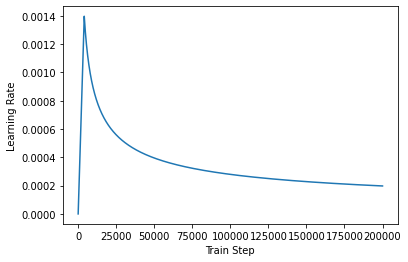

In [74]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 7. 모델 컴파일

In [75]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## 8. 모델 학습 (변경사항 있음)  
-> inputs 삭제, dec_input -> inputs으로 변경

In [76]:
val_ratio = int(len(data) * 0.2)
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
#         'inputs': questions[:val_ratio],                     # 변경사항 : inputs 삭제, dec_input -> inputs으로 변경
        'inputs': answers[:val_ratio, :-1]
    },
    {
        'outputs': answers[:val_ratio, 1:]
    },
))


train_dataset = tf.data.Dataset.from_tensor_slices((
    {
#         'inputs': questions[val_ratio:],                     # 변경사항 : inputs 삭제, dec_input -> inputs으로 변경
        'inputs': answers[val_ratio:, :-1]
    },
    {
        'outputs': answers[val_ratio:, 1:]
    },
))

val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# train dataset shape 확인
print(answers[val_ratio:, :-1].shape)
print(answers[val_ratio:, 1:].shape)

(9457, 27)
(9457, 27)


# *변경사항 : inputs 삭제, dec_input -> inputs으로 변경*  

- GPT1 모델에서는 encoder를 사용하지 않으므로 decoder에 필요한 입력 데이터로 변경

In [77]:
EPOCHS = 50

hist = model.fit(train_dataset,
                 epochs=EPOCHS,
                 validation_data=val_dataset,
                 verbose=1)

Epoch 1/50
148/148 [==============================] - 8s 39ms/step - loss: 2.2063 - accuracy: 0.0390 - val_loss: 1.7911 - val_accuracy: 0.0692
Epoch 2/50
148/148 [==============================] - 5s 35ms/step - loss: 1.8388 - accuracy: 0.0718 - val_loss: 1.4971 - val_accuracy: 0.0692
Epoch 3/50
148/148 [==============================] - 5s 35ms/step - loss: 1.5621 - accuracy: 0.0723 - val_loss: 1.3322 - val_accuracy: 0.0711
Epoch 4/50
148/148 [==============================] - 5s 35ms/step - loss: 1.4176 - accuracy: 0.0761 - val_loss: 1.2664 - val_accuracy: 0.0753
Epoch 5/50
148/148 [==============================] - 5s 35ms/step - loss: 1.3214 - accuracy: 0.0816 - val_loss: 1.2292 - val_accuracy: 0.0781
Epoch 6/50
148/148 [==============================] - 5s 36ms/step - loss: 1.2351 - accuracy: 0.0875 - val_loss: 1.1989 - val_accuracy: 0.0818
Epoch 7/50
148/148 [==============================] - 5s 36ms/step - loss: 1.1487 - accuracy: 0.0951 - val_loss: 1.1739 - val_accuracy: 0.0849

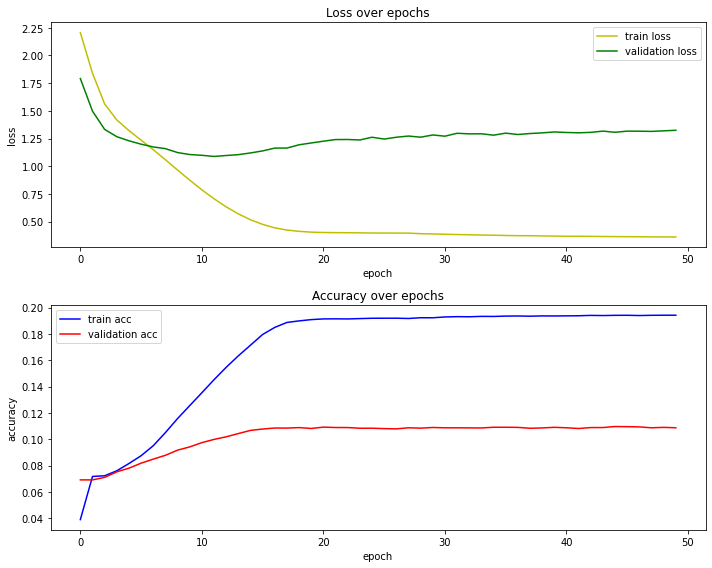

In [78]:
import matplotlib.pyplot as plt

# Subplot 생성 (2개의 그래프: 하나는 loss, 하나는 accuracy)
fig, (loss_ax, acc_ax) = plt.subplots(2, 1, figsize=(10, 8))

# 첫 번째 서브플롯: loss
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
loss_ax.set_title('Loss over epochs')

# 두 번째 서브플롯: accuracy
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'r', label='validation acc')
acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='best')
acc_ax.set_title('Accuracy over epochs')

# 그래프 표시
plt.tight_layout()  # 레이아웃 조정 (여백 자동 조정)
plt.show()


## 9. 챗봇 테스트 하기

새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.  
입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.  
패딩 마스킹과 룩 어헤드 마스킹을 계산한다.  
디코더는 입력 시퀀스로부터 다음 단어를 예측한다.  
디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.  
END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.  

In [79]:
# def decoder_inference(sentence):
#   sentence = preprocess_sentence(sentence)

#   # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
#   # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
#   sentence = tf.expand_dims(
#       START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

#   # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
#   # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
#   output_sequence = tf.expand_dims(START_TOKEN, 0)

#   # 디코더의 인퍼런스 단계
#   for i in range(MAX_LENGTH):
#     # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
#     predictions = model(inputs=[sentence, output_sequence], training=False)
#     predictions = predictions[:, -1:, :]

#     # 현재 예측한 단어의 정수
#     predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

#     # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
#     if tf.equal(predicted_id, END_TOKEN[0]):
#       break

#     # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
#     # 이 output_sequence는 다시 디코더의 입력이 됩니다.
#     output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

#   return tf.squeeze(output_sequence, axis=0)

In [80]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    inputs = tf.concat([sentence, output_sequence], axis=-1)  # 변경사항 : sentence와 output_sequence를 이어붙여서 텐서 변경
    predictions = model(inputs=inputs, training=False)        # 변경사항 : model에 하나의 입력 텐서만 전달

    predictions = predictions[:, -1:, :]  # 예측된 마지막 단어에 대한 확률값을 가져옴

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)


# *변경사항 : 데이터셋 차원 변경에 따라 입력 차원 하나로 변경

In [81]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [83]:
sentence_generation('넌 누구야?')
sentence_generation('밖에 비 온다')
sentence_generation('노래 듣고 싶다')
sentence_generation('영화 재미 없다')

입력 : 넌 누구야?
출력 : 계속 엄청 좋아하는 게 아니라면 나쁜 게 
입력 : 밖에 비 온다
출력 : 저요 .
입력 : 노래 듣고 싶다
출력 : 다른 사람이 답답할 거예요 .
입력 : 영화 재미 없다
출력 : 안 할 자신 있나요 .


'안 할 자신 있나요 .'

결과 : 챗봇보다 엉성한 문장을 만듦. 대화도 이어지지 않는다

# model.summary() 결과 첨부
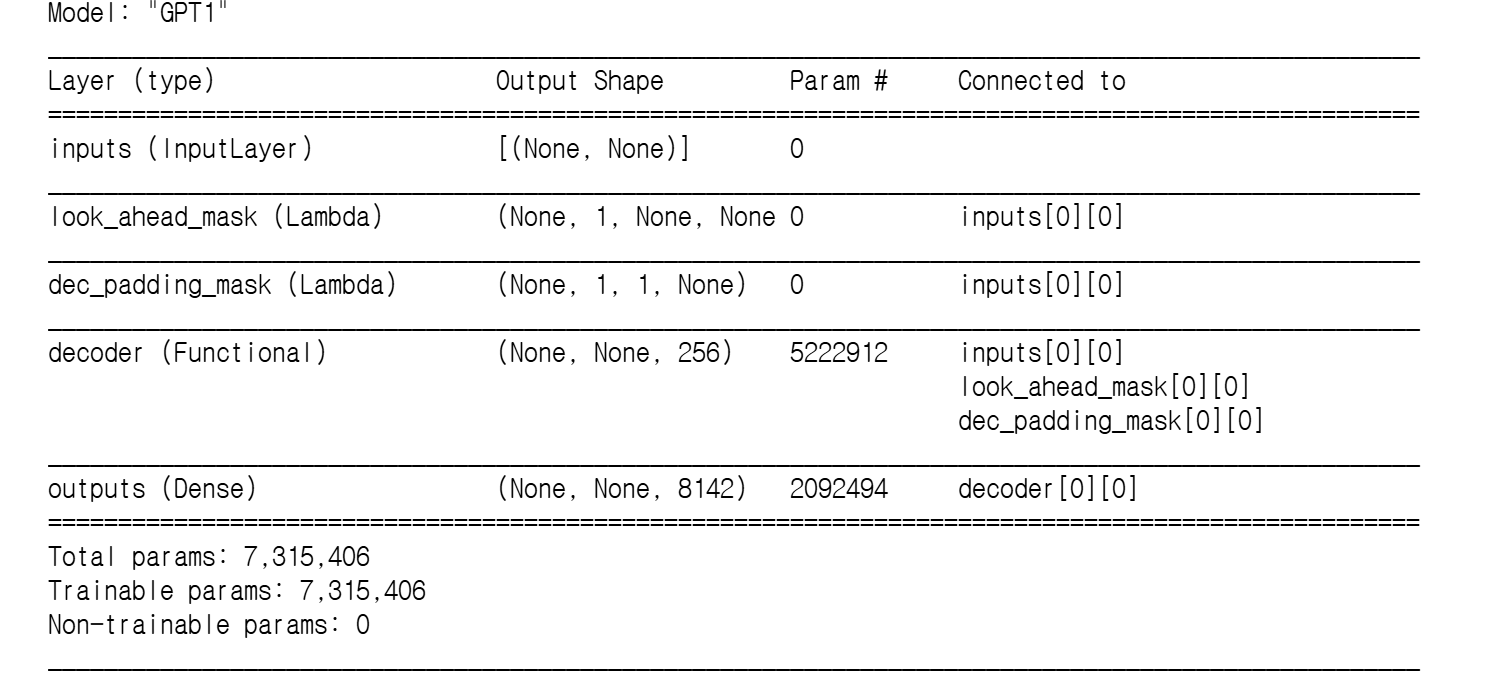


# model.fit() 결과 첨부
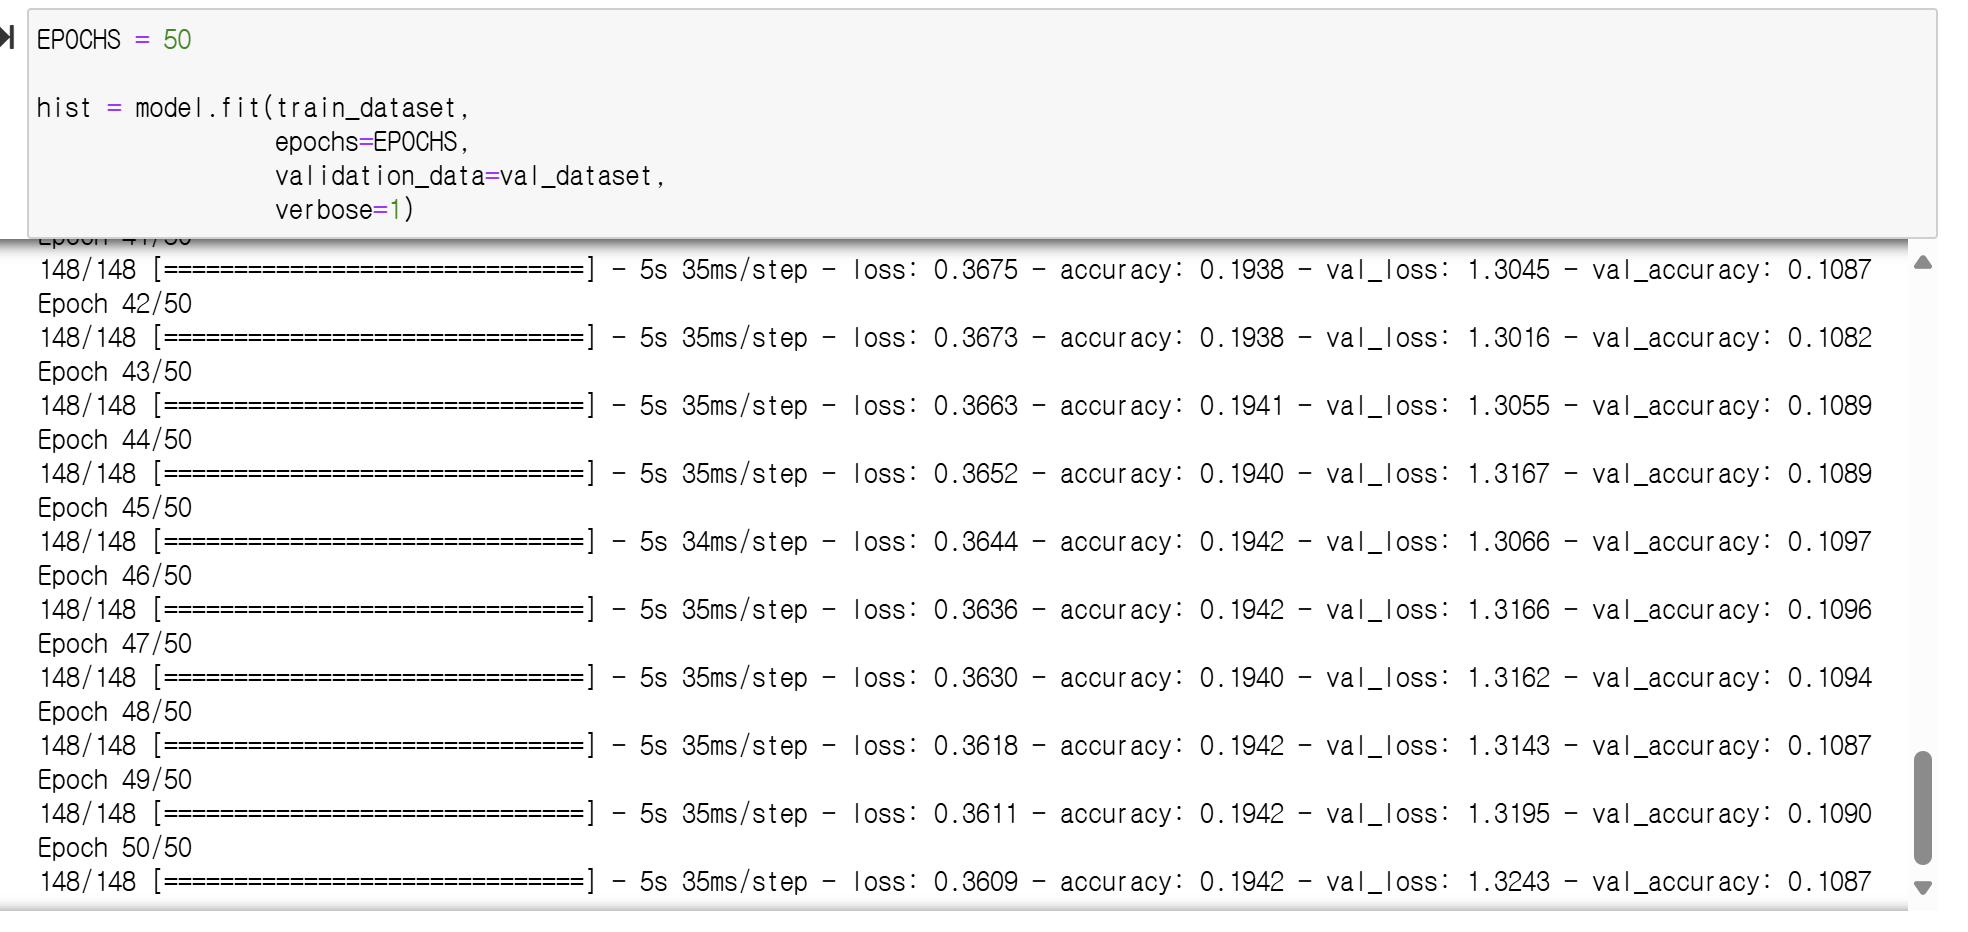
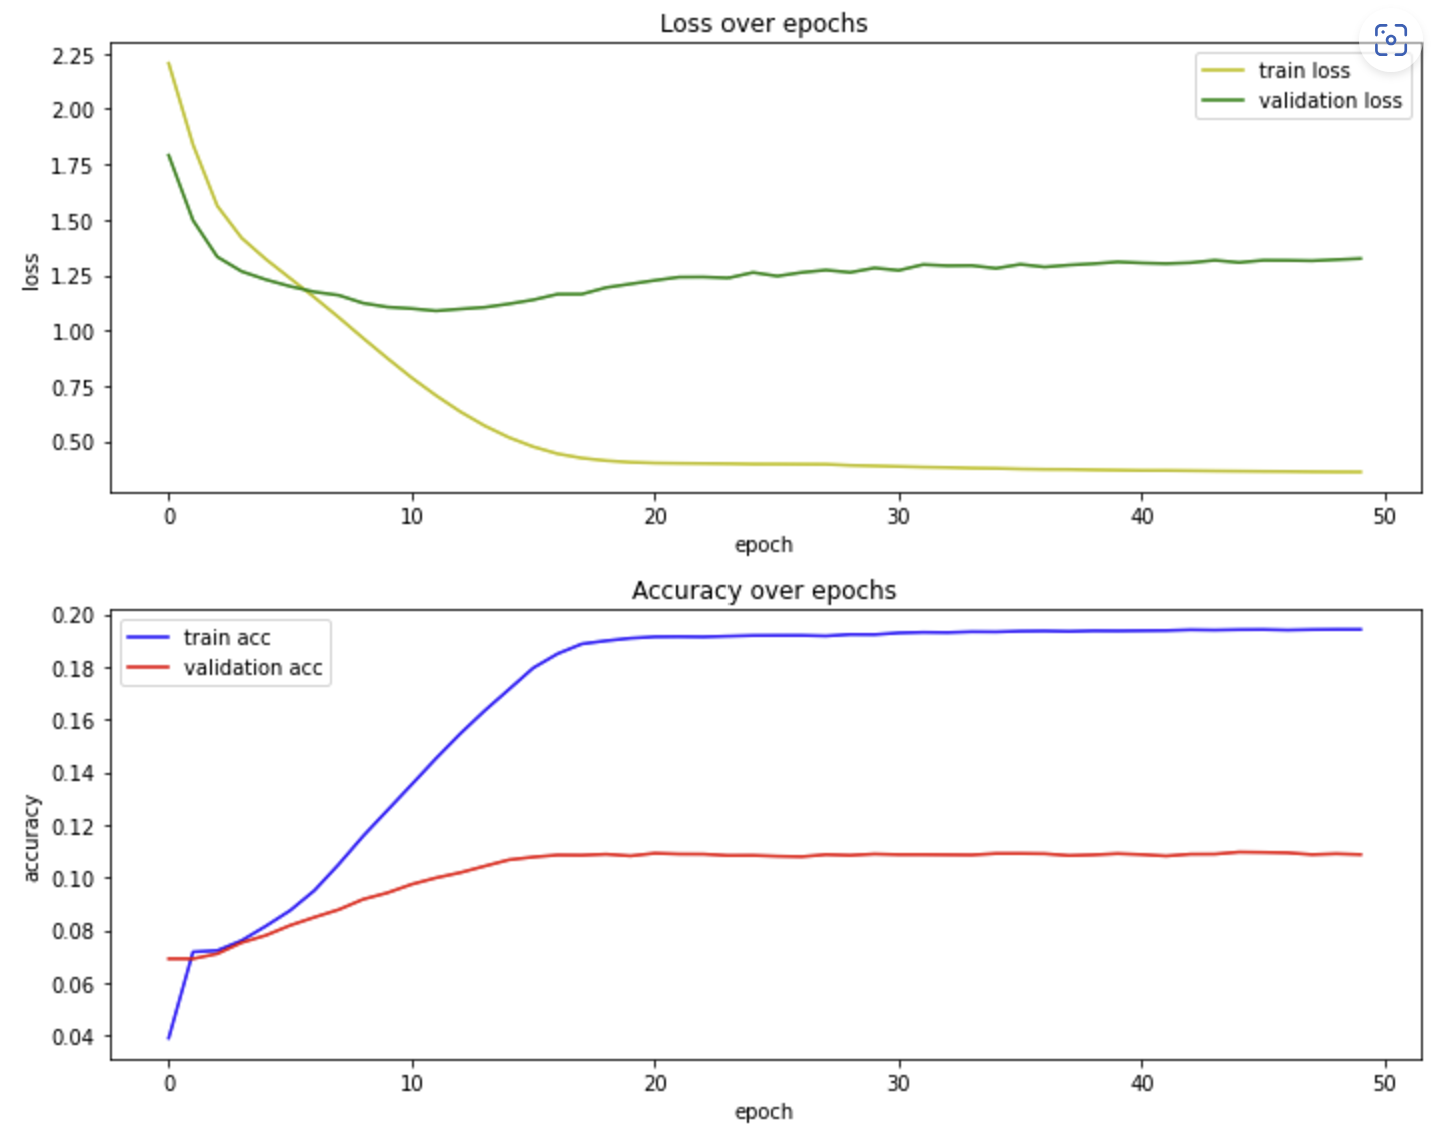



회고 :  
기존 프로젝트를 기반으로 모델을 만들어서 차이점이 잘 느껴지긴 하지만 동시에 맞게 구성하고 있는 건지에 대한 답답함이 계속 들었다.  
구글링으로 코드 구현에 대한 내용을 찾기 힘들어서 Chat GPT로 찾아보았지만 질문에 대한 답을 계속 바꿔서 더 혼란스러웠다.  